In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any
from libraries import scalar_autodiff as ad
from libraries import vector_autodiff as adf

In [2]:
# Reference Iterative Implementation

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x)) 

class IterativeNeuralNetwork:

    layer_dimensions: List[int] = []
    inner_layers: int = 0
    learning_rate: float = 0

    weights: List[np.ndarray] = []
    biases: List[np.ndarray] = []

    def __init__(self, layer_dimensions: List[int], learning_rate: float):
        self.layer_dimensions = layer_dimensions
        self.inner_layers = len(layer_dimensions) - 1
        self.learning_rate = learning_rate

        self.randomize_parameters()
    
    def get_layer_dimension(self, dimension: int) -> int:

        return self.layer_dimensions[dimension]

    def randomize_parameters(self):
        
        self.weights = []
        self.biases = []

        for layer in range(1, self.inner_layers+1):

            last_dim = self.get_layer_dimension(layer - 1)
            this_dim = self.get_layer_dimension(layer)

            self.weights.append(np.random.randn(this_dim, last_dim))
            self.biases.append(np.random.randn(this_dim))

    def run(self, input: List[int]) -> List[int]:
        acc = input
        for layer in range(0, self.inner_layers):
            acc = sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc
    
    def run_to_layer(self, input: List[int], to_layer: int) -> List[int]:
        assert(to_layer <= self.inner_layers)
        acc = input
        for layer in range(0, to_layer):
            acc = sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc

    def get_cost(self, inputs: List[int], expected_output: List[int]) -> float:
        return 0.5 * np.linalg.norm(self.run(inputs) - expected_output) ** 2

    def get_gradients_for(self, input: List[int], expected_output: List[int]) -> tuple[List[np.ndarray], List[np.ndarray]]:
        # forward propagation
        activations = []
        activation_primes = []
        acc = input
        for layer in range(0, self.inner_layers):
            activations.append(acc)

            mult = self.weights[layer] @ acc + self.biases[layer]
            acc = sigmoid(mult)
            activation_primes.append(sigmoid_prime(mult))
            
        activations.append(acc)

        residuals = activations[-1] - expected_output

        bias_gradients: List[np.ndarray] = [None] * self.inner_layers
        weight_gradients: List[np.ndarray] = [None] * self.inner_layers
        
        acc = residuals * activation_primes[self.inner_layers-1]
        for layer in range(self.inner_layers-1, -1, -1):

            bias_gradients[layer] = acc
            weight_gradients[layer] = np.outer(acc, activations[layer])

            if layer != 0: 
                acc = activation_primes[layer-1] * (self.weights[layer].transpose() @ acc)

        return (bias_gradients, weight_gradients)

    def train(self, input: List[int], expected_output: List[int]):

        gradients = self.get_gradients_for(input, expected_output)
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= self.learning_rate * gradients[0][layer]
            self.weights[layer] -= self.learning_rate * gradients[1][layer]
    
    def train_batch(self, inputs: List[List[float]], expected_outputs: List[List[float]]):
        batch_size = len(inputs)
        
        total_bias_gradients = [None] * self.inner_layers
        total_weight_gradients = [None] * self.inner_layers
        for i in range(0, batch_size):

            gradients = self.get_gradients_for(inputs[i], expected_outputs[i])
            
            if i == 0:
                total_bias_gradients = gradients[0]
                total_weight_gradients = gradients[1]
            else:
                for j in range(0, self.inner_layers):
                    total_bias_gradients[j] += gradients[0][j]
                    total_weight_gradients[j] += gradients[1][j]

        for i in range(0, self.inner_layers):        
            total_bias_gradients[i] *= self.learning_rate / batch_size
            total_weight_gradients[i] *= self.learning_rate / batch_size
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= total_bias_gradients[layer]
            self.weights[layer] -= total_weight_gradients[layer]

In [9]:
def test_gradient_iterative(n: int, m: int) -> List[float]:
    layers = [n] * (m+1) # because the input layer is baked in, we need to add an extra here
    nn = IterativeNeuralNetwork(layers, 1)
    input = np.random.randn(n)
    output = np.random.randn(n)
    return nn.train(input, output)

def test_gradient_ad(n: int, m: int) -> List[float]:
    nn = ad.NeuralNetwork(n, [ad.SimpleLayer(n, ad.ActivationFunction.SIGMOID, ad.InitializationType.NORMAL)]*m, 1)
    input = np.random.randn(n)
    output = np.random.randn(n)
    return nn.train(input, output)

def test_gradient_adf(n: int, m: int) -> List[float]:
    nn = adf.NeuralNetwork(n, [adf.SimpleLayer(n, adf.ActivationFunction.SIGMOID, adf.InitializationType.NORMAL)]*m, 1)
    input = np.random.randn(n)
    output = np.random.randn(n)
    return nn.train(input, output)

def time_func(func, n: int, m: int) -> float:
    start = time.time()
    func(n, m)
    end = time.time()
    return end - start

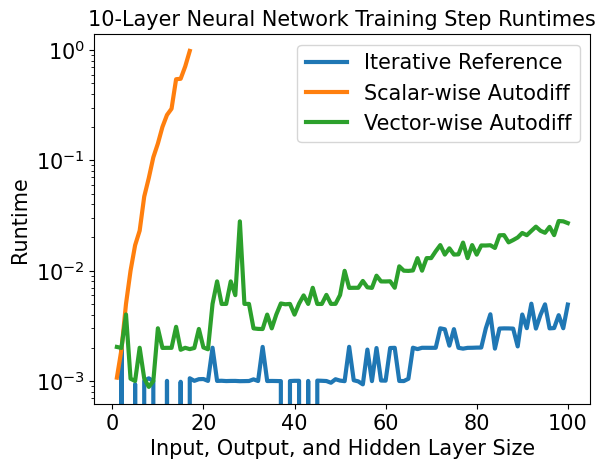

In [10]:
MAX_N = 100
M = 10

times_iter = []
times_adf = []
for i in range(1, MAX_N+1):
    times_iter.append(time_func(test_gradient_iterative, i, M))
    times_adf.append(time_func(test_gradient_adf, i, M))

times_ad = []
for i in range(1, MAX_N+1):
    t = time_func(test_gradient_ad, i, M)
    if t > 1:
        break
    times_ad.append(t)

plt.plot(range(1, MAX_N+1, 1), times_iter, linewidth=3)
plt.plot(range(1, len(times_ad)+1, 1), times_ad, linewidth=3)
plt.plot(range(1, MAX_N+1, 1), times_adf, linewidth=3)
plt.legend(['Iterative Reference', 'Scalar-wise Autodiff', 'Vector-wise Autodiff'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.title("10-Layer Neural Network Training Step Runtimes", fontsize=15)
plt.xlabel("Input, Output, and Hidden Layer Size", fontsize=15)
plt.ylabel("Runtime", fontsize=15)
plt.show()